# CS:GO Cheater Identification
#### S14 Group 6
- Aldecoa, Renzel Raphael
- Bautista, Carlo Gabriel
- Canicon, Jan Ambro

Footnote: We suggest reading through the notebook first before running as our hyperparameter tunings were very slow, and we made it a point to keep the code cell outputs of the notebook uncleared for submission and viewing.

# CS:GO Cheating Dataset
Counter-Strike: Global Offensive (CS:GO) is a first-person tactical shooter for PC. It comes with a competitive ranked game mode where people play against players of a similar skill level in order to try and improve their rank. One of the major problems for playing the ranked playlist is the chance of encountering a cheater, of which almost guarantees the loss of the team facing against players using cheats. CS:GO has an anti-cheat system through the Valve Anti-Cheat, however this functions by detecting the interaction of external application with the game files. To detect cheaters, machine learning may be used to detect patterns in their playstyle, such as how they can lock onto targets using cheats. In theory, a cheater will have **more consistent input** or **instantaneous changes in aim direction** in between timestamps.

The [dataset from Kaggle](https://www.kaggle.com/datasets/emstatsl/csgo-cheating-dataset) used contains gameplay input from players, segregated into non-cheating ("**legit**") and cheating players ("**cheaters**"). The main task with the dataset is to categorize players as cheating or not based on their game input. There are a total of `12 000` samples in the dataset, divided into two groups of `10 000` legit players and `2 000` cheaters.

***

The dataset has a shape of `[X, 30, 192, 5]`, named as `[player, engagement, game_tick, player_input]`.

**Player**
- This refers to the number of players in the subset
- There are `10 000` legit players and `2 000` cheaters

**Engagement**
- This specifies the encounter with other players

**Game Tick**
- This is the in-game time increment that holds player vectors and other game information
- CS:GO competitive servers commonly have 64 ticks in a second, meaning that this is 3 seconds worth of input

**Player Input**
- Input sent by players, **which are the main features of the dataset**

***

The **Player Input** features of the dataset are divided into a list as `[AttackerDeltaYaw, AttackerDeltaPitch, CrosshairToVictimYaw, CrosshairToVictimPitch, Firing]`.

**AttackerDeltaYaw** and **AttackerDeltaPitch**
- Change in the direction of the attacking player’s aim
- The higher this is, the higher the speed of the mouse input

**CrosshairToVictimYaw** and **CrosshairToVictimPitch**
- Distance remaining between the attacker’s crosshair and target’s hitbox
- The lower this is, the closer the attacker's crosshair is to the target

**Firing**
    - Whether the attacker is firing or not

Additionally note that *Yaw* refers to the left-right movement axis, and *Pitch* refers to up-down movement axis. These are measures in 360-degrees, with a range of `[-180, 180]`.

# Dependencies
- [CS:GO Cheating Dataset](https://www.kaggle.com/datasets/emstatsl/csgo-cheating-dataset) (Both legit.npy and cheaters.npy)
    - For use here, each file must be located in the same directory as the notebook
- numpy
- pandas
- matplotlib
- sklearn
- TensorFlow
- Keras
- Keras-tuner

# Library Imports and Notebook Initialization

In [47]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Interpretation
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Decision Tree/Ensemble Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from tensorflow.python.client import device_lib
import keras_tuner

# Fix floats to display decimals instead of exponential notation
pd.options.display.float_format = '{0:.4f}'.format

## Loading the dataset

In [79]:
legit_data = np.load('legit.npy')
cheaters_data = np.load('cheaters.npy')

print('Legit:', legit_data.shape)
print('Cheaters:', cheaters_data.shape)

Legit: (10000, 30, 192, 5)
Cheaters: (2000, 30, 192, 5)


# Exploratory Data Analysis
Theories
- If yaw/pitch move by X, cheater crosshair should move X closer to target
- Cheaters have low CrosshairToVictimPitch (aim is locked on, or always very close)

TODO
- Cheaters data may not be all instances of cheating
- Some suspicious behavior from legit may be because of ingame strategy (i.e. trigger discipline)
- Accuracy is likely to be impacted because of these ambiguous characteristics, unspecified by dataset creator
- Graph of cheater that does not appear cheating, graph of legit that appears cheating
- Cheating = consistently low CrosshairToTarget

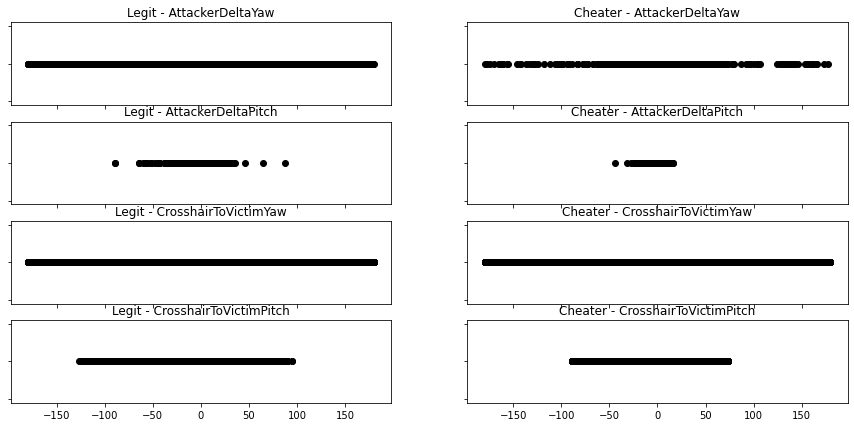

In [3]:
movements = [
    legit_data[:, 0, :, 0],
    legit_data[:, 0, :, 1],
    legit_data[:, 0, :, 2],
    legit_data[:, 0, :, 3],
    cheaters_data[:, 0, :, 0],
    cheaters_data[:, 0, :, 1],
    cheaters_data[:, 0, :, 2],
    cheaters_data[:, 0, :, 3]
]
labels = [
    'Legit - AttackerDeltaYaw',
    'Legit - AttackerDeltaPitch',
    'Legit - CrosshairToVictimYaw',
    'Legit - CrosshairToVictimPitch',
    'Cheater - AttackerDeltaYaw',
    'Cheater - AttackerDeltaPitch',
    'Cheater - CrosshairToVictimYaw',
    'Cheater - CrosshairToVictimPitch'
]

fig, axs = plt.subplots(4, 2, figsize=(15, 7), sharex=True)
for ax, movement, label in zip(axs.flatten(order='F'), movements, labels):
    ax.scatter(movement, np.zeros_like(movement), color='black')
    ax.set_title(label)
    ax.set_yticklabels([])
plt.show()

It can be seen that the values are spread across a wide range, which is is understandable because players can aim in a 360-degree area. However, values like these will not be removed as there exists cheats in CS:GO wherein cheaters can instantaneously lock-in on a target behind or below them. The scatter plot of `Cheater - AttackDeltaYaw` is interesting because it does not show a completely solid line unlike the Legit counterpart. What this can mean is that the input of Cheaters have significantly less variation compared to Legit players.

Since there is a large disparity between the values of the dataset, preprocessing through normalization must be done.

We can also check the changes in the players' aim and the distance of their crosshair to the targets as time goes by. We manually go through the instances in order to look for behaviors that match our assumptions.

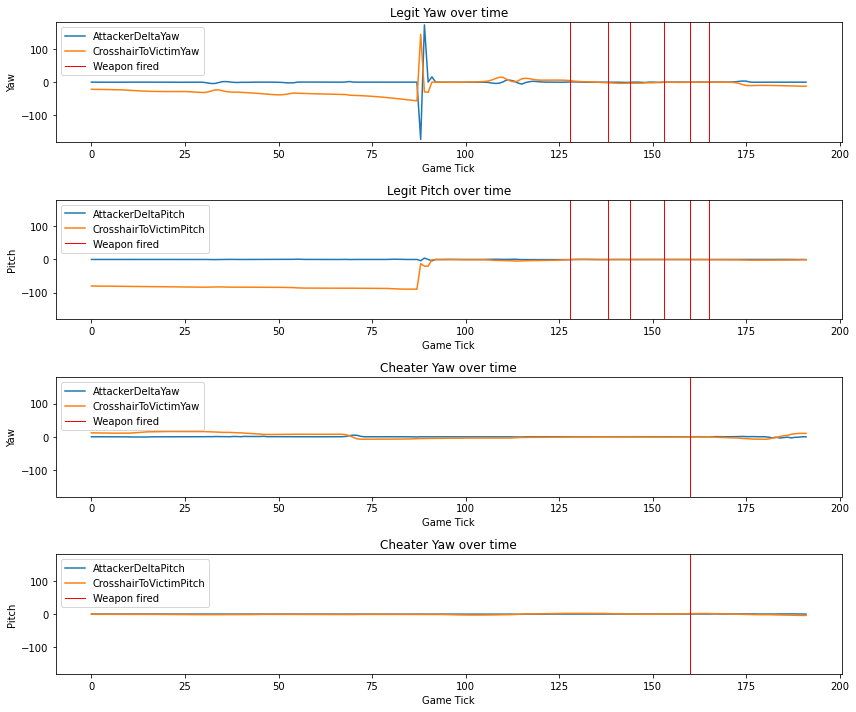

In [4]:
# Gets specific player engagement
# Legit range [0:9999][0:29]
# Cheater range [0:1999][0:29]
legit = legit_data[0, 0, :, :]
cheater = cheaters_data[0, 0, :, :]

legit_firing = np.where(legit[:, 4] == 1)
cheater_firing = np.where(cheater[:, 4] == 1)

fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(411)
ax1.set_title('Legit Yaw over time')
plt.plot(legit[:, 0], label='AttackerDeltaYaw')
plt.plot(legit[:, 2], label='CrosshairToVictimYaw')
[plt.axvline(x, linewidth=1, color='r') for x in legit_firing[0]]
ax1.lines[-1].set_label('Weapon fired')
ax1.set_ylim([-180, 180])
ax1.set_xlabel('Game Tick')
ax1.set_ylabel('Yaw')
plt.legend(loc='upper left')

ax2 = fig.add_subplot(412)
ax2.set_title('Legit Pitch over time')
plt.plot(legit[:, 1], label='AttackerDeltaPitch')
plt.plot(legit[:, 3], label='CrosshairToVictimPitch')
[plt.axvline(x, linewidth=1, color='r') for x in legit_firing[0]]
ax2.lines[-1].set_label('Weapon fired')
ax2.set_ylim([-180, 180])
ax2.set_xlabel('Game Tick')
ax2.set_ylabel('Pitch')
plt.legend(loc='upper left')

ax3 = fig.add_subplot(413)
ax3.set_title('Cheater Yaw over time')
plt.plot(cheater[:, 0], label='AttackerDeltaYaw')
plt.plot(cheater[:, 2], label='CrosshairToVictimYaw')
[plt.axvline(x, linewidth=1, color='r') for x in cheater_firing[0]]
ax3.lines[-1].set_label('Weapon fired')
ax3.set_ylim([-180, 180])
ax3.set_xlabel('Game Tick')
ax3.set_ylabel('Yaw')
plt.legend(loc='upper left')

ax4 = fig.add_subplot(414)
ax4.set_title('Cheater Yaw over time')
plt.plot(cheater[:, 1], label='AttackerDeltaPitch')
plt.plot(cheater[:, 3], label='CrosshairToVictimPitch')
[plt.axvline(x, linewidth=1, color='r') for x in cheater_firing[0]]
ax4.lines[-1].set_label('Weapon fired')
ax4.set_ylim([-180, 180])
ax4.set_xlabel('Game Tick')
ax4.set_ylabel('Pitch')
plt.legend(loc='upper left')

fig.tight_layout()

Notice that in the time series graph of a Legit player's Yaw, the direction jumps from the bottom of the negative area to the top of the positive area. Behavior like this is not abnormal; yaw vectors wrap around the `-180` and `+180` limits since they signify the start and end points of the 360-degree aiming area.

What is notable about these two graphs displaying Legit and Cheater aim vectors over time is that the Cheater's pitch and yaw is completely consistent across the 192 ticks of time, which is 3 seconds. Additionally, the `AttackerDelta` and `CrosshairToVictim` of the Cheater mirror each other for both pitch and yaw—this means that each change in the Cheater's aim moves the crosshair towards the target. This is an important note as to how the aiming direction of a Cheater is likely to behave. Notice as well that the Legit player fires several times during the time that the `CrosshairToVictim` is closest to zero, whereas the `Cheater` only fires once, signifying a likelihood that the Cheater hit their shot on the first try. With these, we can assume that a Cheater's behavior is noticeably different from that of a Legit player.

One limitation is that while the author of the dataset identified the cheaters, they did not specify if all engagements of the cheaters are instances of cheating. If that is not the case, it will impact the training and the accuracy of the model later on if, for example, a cheater cheats in only 1 engagement out of 30. Using the following code, we manually sifted through the Cheater dataset to verify if it is completely comprised of instances of cheating. From what we analyzed, it seems that the entire Cheater dataset is completely composed of instances of cheating; thus all work on the models is under this assumption.

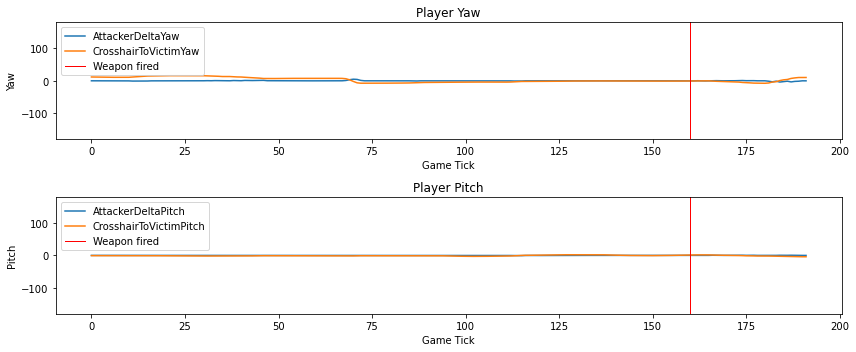

In [80]:
# CHANGE THESE
# 0 -1999
player = 0
# 0 - 29
engagement = 0

# Gets specific player engagement
cheater = cheaters_data[player, engagement, :, :]
cheater_firing = np.where(cheater[:, 4] == 1)

fig = plt.figure(figsize=(12,5))

ax3 = fig.add_subplot(211)
ax3.set_title('Player Yaw')
plt.plot(cheater[:, 0], label='AttackerDeltaYaw')
plt.plot(cheater[:, 2], label='CrosshairToVictimYaw')
[plt.axvline(x, linewidth=1, color='r') for x in cheater_firing[0]]
ax3.lines[-1].set_label('Weapon fired')
ax3.set_ylim([-180, 180])
ax3.set_xlabel('Game Tick')
ax3.set_ylabel('Yaw')
plt.legend(loc='upper left')

ax4 = fig.add_subplot(212)
ax4.set_title('Player Pitch')
plt.plot(cheater[:, 1], label='AttackerDeltaPitch')
plt.plot(cheater[:, 3], label='CrosshairToVictimPitch')
[plt.axvline(x, linewidth=1, color='r') for x in cheater_firing[0]]
ax4.lines[-1].set_label('Weapon fired')
ax4.set_ylim([-180, 180])
ax4.set_xlabel('Game Tick')
ax4.set_ylabel('Pitch')
plt.legend(loc='upper left')

fig.tight_layout()

Here are the working assumptions for the interpretation of the preceding graph, that signifies cheating behavior:
- Consistent `CrosshairToVictim` vector across the entire time period
- Overly-jerky movement of `AttackerDelta`
- Low amount of `Weapon fired`
- Consistent spacing between timestamps of `Weapon fired`

Additionally, because CS:GO can be played in different ways, there can be an instance where a Legit player can be recognized as Cheating, if we simply look at graphs like these without context. An example situation of this would be a Legit player aiming at a stationary target. This would be visualized as a graph with low CrosshairToVictim aim vectors, as the Legit player could have been centering their aim on the target for the whole duration. A possible example of this is shown below.

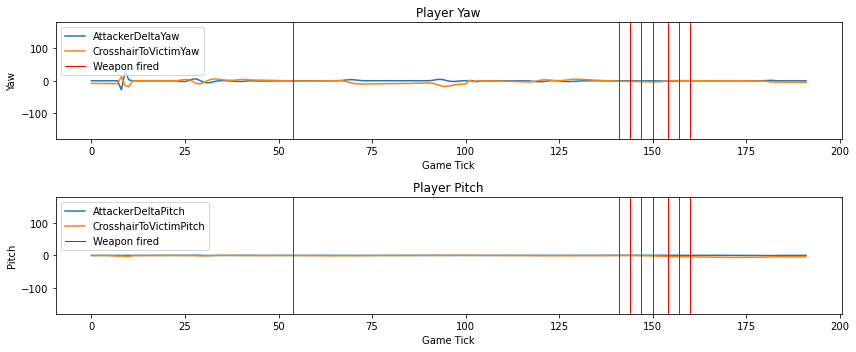

In [82]:
# Gets specific player engagement
legit = legit_data[0, 4, :, :]

legit_firing = np.where(legit[:, 4] == 1)

fig = plt.figure(figsize=(12,5))

ax3 = fig.add_subplot(211)
ax3.set_title('Player Yaw')
plt.plot(legit[:, 0], label='AttackerDeltaYaw')
plt.plot(legit[:, 2], label='CrosshairToVictimYaw')
[plt.axvline(x, linewidth=1, color='r') for x in legit_firing[0]]
ax3.lines[-1].set_label('Weapon fired')
ax3.set_ylim([-180, 180])
ax3.set_xlabel('Game Tick')
ax3.set_ylabel('Yaw')
plt.legend(loc='upper left')

ax4 = fig.add_subplot(212)
ax4.set_title('Player Pitch')
plt.plot(legit[:, 1], label='AttackerDeltaPitch')
plt.plot(legit[:, 3], label='CrosshairToVictimPitch')
[plt.axvline(x, linewidth=1, color='r') for x in legit_firing[0]]
ax4.lines[-1].set_label('Weapon fired')
ax4.set_ylim([-180, 180])
ax4.set_xlabel('Game Tick')
ax4.set_ylabel('Pitch')
plt.legend(loc='upper left')

fig.tight_layout()

# Data Preprocessing

The dataset is stored in a format of `[player, engagement, game_tick, player_input]`. To give the models interpretable data, we further flatten it by combining `engagement`, `game_tick`, and `player_input`, as these all represent the input of a player, just that it is spread over dimensions as different periods of time (`engagement`), for a specific duration (`game_tick`).

After flattening the dimensions, we can also combine the two datasets.

In [4]:
# Flatten features
legit_data = legit_data.reshape(10000, 28800)
cheaters_data = cheaters_data.reshape(2000, 28800)

# Combine legit and cheater datasets
X_players = np.vstack([legit_data, cheaters_data])
print('Training data shape:', X_players.shape)

Training data shape: (12000, 28800)


The dataset does not include a list of ground truth values, but the two classes are separated in two files and we simply append the cheaters to the end of the list of legit players. Because of this, we can easily create a list that contains their classes by using the length of each list. The classes will be:
- `0` — `Legit` player
- `1` — `Cheating` player

In [5]:
# Create truth values for combined list
y_players = np.append(
        np.zeros(legit_data.shape[0], dtype=int),
        np.full(cheaters_data.shape[0], 1, dtype=int)
)
print('Ground truth values shape:', y_players.shape)

Ground truth values shape: (12000,)


We also normalize the data using `MinMaxScaler` from `scikit-learn`, since the values can range from `-180` which would be interpreted as an undesirable record to learn from because of its low value compared to the upper limits of the values at `+180`.

In [6]:
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_players.reshape(-1,1))
X_normalized = X_normalized.reshape(12000, 28800)

With the normalized data, we split into two subsets of train and test sets at a ratio of 70:30. We will not be splitting the train set further as the `RandomSearchCV` and `GridSearchCV` methods, as well as the built-in methods of `Keras`, automatically takes a subset of the train set to use as a validation set during the process of hyperparameter tuning.

In [7]:
# Dataset splitting
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_players, test_size=0.3, random_state=0, stratify=y_players)

# Print results
print('Split results:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

# Print class counts
unique, counts = np.unique(y_train, return_counts=True)
print("Training data label counts:")
print(np.array([unique, counts]))
unique, counts = np.unique(y_test, return_counts=True)
print("Test data label counts:")
print(np.array([unique, counts]))

Split results:
X_train: (8400, 28800)
y_train: (8400,)
X_test: (3600, 28800)
y_test: (3600,)
Training data label counts:
[[   0    1]
 [7000 1400]]
Test data label counts:
[[   0    1]
 [3000  600]]


An additional step of preprocessing, although not data, is to prepare the functions `compute_accuracy`.

In [8]:
def compute_accuracy(predictions, actual):
    return np.sum(predictions == actual) / len(actual)

# Model Training
Our original plan of action was to use the **Logistic Regression** model as a method of classification. However, after the proposal presentation and the neural networks lecture, we decided to move to the higher level of **Neural Networks** for our planned model. After some research, we found that the most popular neural network library for Python is **Keras**, so we looked for models that utilize it so that we could reference how they built their model. From this, we found **Convolutional Neural Networks (CNNs)**; however, we noticed that the most common application of CNNs is for images. Because of this, we decided instead to do the standard implementation of neural networks similar to those in the lectures. This was done using the combination of the **Keras** and **TensorFlow** libraries.

- Thought of using logreg as the final model, but decided to look for neural networks
    - Because neural networks use logistic regression in the layers
- Conduct research which libraries best for neural networks
    - Found keras
- Find models basing on keras
    - Found that most of these are for images
- Conduct research which algorithms best for classification
    - found the models used in the previous notebooks
- Look for better libraries of logreg, etc. for python, still found scikit-learn
- Decided "lower level" models to "higher level" ones, comparing their accuracy


1. logreg
2. naive bayes
3. ensemble models
4. Neural networks

## Logistic Regression
We first set a baseline for accuracy using the logistic regression model from scikit-learn.

In [13]:
lr = LogisticRegression(solver='liblinear', max_iter=200, random_state=5)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=5, solver='liblinear')

In [14]:
predictions = lr.predict(X_train)
print('Train Accuracy:', compute_accuracy(predictions, y_train))
predictions = lr.predict(X_test)
print('Validation Accuracy:', compute_accuracy(predictions, y_test))

Train Accuracy: 0.8885714285714286
Validation Accuracy: 0.8005555555555556


Initial training on the default logistic regression model yielded a train accuracy of 86.42% and a test accuracy of 80.05%

### LogReg Hyperparameter Tuning
The hyperparameters that we tune for logistic regression are only `solver` and `C`. There is also the `penalty` hyperparameter according to scikit-learn's documentation of the `LogisticRegression` class, however we chose not to use it as the other options for `penalty` (i.e. `l1`, `elasticnet`) are only compatible with the `saga` solver; the `none` penalty meanwhile warns about the `C` parameter being ignored. For the solver, we choose `liblinear` in addition to the default `lbfgs` since it is suited for smaller datasets. However according to tests from Hale (2019), there is usually minimal difference between solver options.

In [15]:
# L1 and elasticnet are excluded from the hyperparameters because they are incompatible with sag
# Penalty is removed because left is none and l2, and none does not use C
hyperparameters = {
    'solver': ['liblinear', 'lbfgs'],
    'C': [20, 5, 1.0, 0.01, 0.01]
}
lrhp = LogisticRegression(max_iter=200, random_state=5)
rsr = GridSearchCV(estimator=lrhp, param_grid=hyperparameters, cv=5)

In [16]:
rsr.fit(X_train, y_train)

c:\Users\Jan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Jan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=200, random_state=5),
             param_grid={'C': [20, 5, 1.0, 0.01, 0.01],
                         'solver': ['liblinear', 'lbfgs']})

In [17]:
rsr.best_params_

{'C': 0.01, 'solver': 'liblinear'}

### Retraining on best hyperparameters

In [54]:
best_lr = LogisticRegression(solver='liblinear', C=0.01, random_state=5)
best_lr.fit(X_train, y_train)

predictions = best_lr.predict(X_train)
print('Train Accuracy:', compute_accuracy(predictions, y_train))
predictions = best_lr.predict(X_test)
print('Validation Accuracy:', compute_accuracy(predictions, y_test))

Train Accuracy: 0.833452380952381
Validation Accuracy: 0.8333333333333334


After finding the best hyperparameters from our given set, the model yielded a train accuracy of **83.34%** and a test accuracy of **83.33%**.

## Neural Network
Using the results of the logistic regression model, we want to see if the higher level of the neural network model could give us a higher accuracy for the tests.

In [ ]:
print(device_lib.list_local_devices())
#Creates a session to use the GPU for the neural network
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15759789766368933751
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5738397696
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5115267982015382926
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:06:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:06:00.0, compute capability: 8.6



Since we don't use the scikit-learn libary for the neural network, we split the data set into a train, validation, and test set in order to use the methods from the Keras library. The dataset is split in an 80:20 ratio for the train and test set, and the train set is further split in an 80:20 ratio to divide it into the actual train set and the validation set. 

In [ ]:
# Split Train,Test, and Val set
X_train,X_test,y_train,y_test = train_test_split(X_players,y_players,random_state= 0,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state= 0,test_size=0.2)

We created a Keras pipeline with arbitrary layers in order to initially process the data and see its accuracy.

In [ ]:
batch=32

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
X_train.shape    
num_epochs = 40
model.fit(X_train, y_train, epochs=num_epochs,batch_size=batch,validation_split=0.2)

Epoch 1/40
192/192 [==============================] - 3s 7ms/step - loss: 0.6845 - accuracy: 0.8016 - val_loss: 0.7103 - val_accuracy: 0.8392
Epoch 2/40
192/192 [==============================] - 1s 6ms/step - loss: 0.5161 - accuracy: 0.8257 - val_loss: 0.4877 - val_accuracy: 0.8320
Epoch 3/40
192/192 [==============================] - 1s 5ms/step - loss: 0.5158 - accuracy: 0.8223 - val_loss: 0.5222 - val_accuracy: 0.8418
Epoch 4/40
192/192 [==============================] - 1s 5ms/step - loss: 0.4999 - accuracy: 0.8270 - val_loss: 0.4632 - val_accuracy: 0.8418
Epoch 5/40
192/192 [==============================] - 1s 6ms/step - loss: 0.5073 - accuracy: 0.8276 - val_loss: 0.4868 - val_accuracy: 0.8307
Epoch 6/40
192/192 [==============================] - 1s 5ms/step - loss: 0.4831 - accuracy: 0.8270 - val_loss: 0.5298 - val_accuracy: 0.8411
Epoch 7/40
192/192 [==============================] - 1s 5ms/step - loss: 0.4734 - accuracy: 0.8289 - val_loss: 0.4982 - val_accuracy: 0.8320
Epoch 

Using the summary() and evaluate function, the model details (output shape,layers, layer types, and params) and model accuracy can be checked.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (32, 5)                   144005    
                                                                 
 dense_1 (Dense)             (32, 32)                  192       
                                                                 
 dense_2 (Dense)             (32, 32)                  1056      
                                                                 
 dense_3 (Dense)             (32, 1)                   33        
                                                                 
Total params: 145,286
Trainable params: 145,286
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate model performance
results = model.evaluate(X_test, y_test, batch_size=batch)

75/75 [==============================] - 0s 3ms/step - loss: 0.7467 - accuracy: 0.8229


### Neural Network Hyperparameter Tuning
In order to find the best parameters, we create a function that can create a variable model based on a set of hyperparameters given by Keras_tuner. These will modify base models of the Keras neural network in order to find the optimal configuration. The Hyperparameters that the tuner needs to work on are the number of hidden layers, the activation functions of the layers, the dropout layers, and the learning rate.

In [ ]:
#Base model for hyperparameters
def build_model(hp):
    #Instantiate a Keras Sequential model
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=960, step=32),
                activation=hp.Choice("activation", ["relu", "tanh","elu","selu"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="sigmoid"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
# build model using hyper parameters
build_model(keras_tuner.HyperParameters())

In [ ]:
#Set objectives and parameters for searching for the best model based on accuracy
tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_accuracy",
    max_epochs=10,
    factor=3,
    overwrite=True,
    directory="res"
)
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 960, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 11s]
val_accuracy: 0.8424479365348816

Best val_accuracy So Far: 0.8430989384651184
Total elapsed time: 00h 03m 14s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(X_train.shape))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (7680, 28800)             0         
                                                                 
 dense (Dense)               (7680, 384)               11059584  
                                                                 
 dense_1 (Dense)             (7680, 160)               61600     
                                                                 
 dense_2 (Dense)             (7680, 896)               144256    
                                                                 
 dense_3 (Dense)             (7680, 1)                 897       
                                                                 
Total params: 11,266,337
Trainable params: 11,266,337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tuner.results_summary()

Results summary
Results in res\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 3
units_0: 384
activation: tanh
dropout: False
lr: 0.0001261677614273853
units_1: 160
units_2: 896
units_3: 64
units_4: 320
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8430989384651184
Trial summary
Hyperparameters:
num_layers: 3
units_0: 800
activation: tanh
dropout: True
lr: 0.00012219683223014508
units_1: 416
units_2: 640
units_3: 768
units_4: 800
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.8430989384651184
Trial summary
Hyperparameters:
num_layers: 3
units_0: 800
activation: tanh
dropout: True
lr: 0.00012219683223014508
units_1: 416
units_2: 640
units_3: 768
units_4: 800
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0018
Score: 0.8430989384651184
Trial summary
Hyperparameters:
num_layers: 5
units_0: 736
activation: tanh
dropout: True
lr: 0.00829014608439077


In [ ]:
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = tuner.hypermodel.build(best_hps[0])
# Fit with the entire dataset.
x_all = np.concatenate((X_train, X_val))
y_all = np.concatenate((y_train, y_val))
model.fit(x_all, y_all, epochs=50, validation_split=0.2)

Epoch 1/50
240/240 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8273 - val_loss: 0.0000e+00 - val_accuracy: 0.8375
Epoch 2/50
240/240 [==============================] - 2s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8350 - val_loss: 0.0000e+00 - val_accuracy: 0.8380
Epoch 3/50
240/240 [==============================] - 2s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8350 - val_loss: 0.0000e+00 - val_accuracy: 0.8380
Epoch 4/50
240/240 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8350 - val_loss: 0.0000e+00 - val_accuracy: 0.8380
Epoch 5/50
240/240 [==============================] - 2s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8350 - val_loss: 0.0000e+00 - val_accuracy: 0.8380
Epoch 6/50
240/240 [==============================] - 2s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8350 - val_loss: 0.0000e+00 - val_accuracy: 0.8380
Epoch 7/50
240/240 [==============================] - 2s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=batch)

75/75 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8254


We found that the accuracy of the neural network model did not improve much on the accuracy we took received the logistic regression model. The neural network model yielded a train accuracy of 83.50% and a test accuracy of 82.54%. Before assuming that this was possibly caused by the data, we decided to also check the accuracy of other lower level models.

## Additional Models
Since we performed classification that only involved two classes, we were still open to a variety of models. After doing some research, we found that the best models for classification were already the ones discussed during the course. Specifically, we decided on **Naive Bayes** and **Decision Trees/Ensemble Models**. After looking for additional libraries for classification, we found that the most commonly used ones are found under **scikit-learn**. As such, we used **scikit-learn**'s **MultinomialNB**, **DecisionTreeClassifier**, and **RandomForestClassifier** as additional comparisons of accuracy. 

## Naive Bayes
The first additional model for comparison is a *Multinomial Naive Bayes* model.

In [ ]:
# Initialize and train Naive Bayes model with default parameters
mNB = MultinomialNB()
mNB.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Predict using training data and get accuracy
predictions = mNB.predict(X_train)
print('Train Accuracy:', compute_accuracy(predictions, y_train))

Train Accuracy: 0.8303571428571429


In [ ]:
# Predict using testing data and get accuracy
predictions = mNB.predict(X_test)
print('Train Accuracy:', compute_accuracy(predictions, y_test))

Train Accuracy: 0.8291666666666667


The initial *MultinomialNB* model yielded a training accuracy of **83.04%** and a testing accuracy of **82.92%**.

### Hyperparameter Tuning
The parameters for a *MultinomialNB* model are as follows:
- *alpha* - Determines additive/laplace smoothing
- *fit_prior* - Determines whether to learn class prior probabilities or not

In [ ]:
# Initialize MultinomialNB model using default parameters
mNB = MultinomialNB()

In [ ]:
# List down possible parameters for a MultinomialNB model
hyperparameters = [{
    'alpha': [1, 3, 5, 10, 15, 20, 50],
    'fit_prior': [True, False]
}]

In [ ]:
# Use GridSearchCV to find the best parameters
gsnb = GridSearchCV(estimator=mNB, param_grid=hyperparameters, cv=5, verbose=5)
gsnb.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END ...........alpha=1, fit_prior=True;, score=0.829 total time=   1.1s
[CV 2/5] END ...........alpha=1, fit_prior=True;, score=0.827 total time=   1.1s
[CV 3/5] END ...........alpha=1, fit_prior=True;, score=0.826 total time=   1.1s
[CV 4/5] END ...........alpha=1, fit_prior=True;, score=0.829 total time=   1.2s
[CV 5/5] END ...........alpha=1, fit_prior=True;, score=0.827 total time=   1.1s
[CV 1/5] END ..........alpha=1, fit_prior=False;, score=0.537 total time=   1.1s
[CV 2/5] END ..........alpha=1, fit_prior=False;, score=0.531 total time=   1.3s
[CV 3/5] END ..........alpha=1, fit_prior=False;, score=0.529 total time=   1.2s
[CV 4/5] END ..........alpha=1, fit_prior=False;, score=0.543 total time=   1.2s
[CV 5/5] END ..........alpha=1, fit_prior=False;, score=0.527 total time=   1.2s
[CV 1/5] END ...........alpha=3, fit_prior=True;, score=0.829 total time=   1.2s
[CV 2/5] END ...........alpha=3, fit_prior=True;

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid=[{'alpha': [1, 3, 5, 10, 15, 20, 50],
                          'fit_prior': [True, False]}],
             verbose=5)

In [ ]:
# Get best parameters through GridSearchCV
gsnb.best_params_

{'alpha': 50, 'fit_prior': True}

### Retrainining model with best parameters

In [52]:
# Initialize and train new MultinomialNB model using the best parameters according to GridSearchCV
mNB = MultinomialNB(alpha=50, fit_prior=True)
mNB.fit(X_train, y_train)

MultinomialNB(alpha=50)

In [ ]:
# Predict using training data and get accuracy
predictions = mNB.predict(X_train)
print('Train Accuracy:', compute_accuracy(predictions, y_train))

Train Accuracy: 0.8308333333333333


In [ ]:
# Predict using testing data and get accuracy
predictions = mNB.predict(X_test)
print('Train Accuracy:', compute_accuracy(predictions, y_test))

Train Accuracy: 0.8316666666666667


With the best parameters, the *MultinomialNB* model yielded a training accuracy of **83.08%** and a testing accuracy of **83.17%**.

## Decision Tree
The next type of model is a *DecisionTreeClassifier*.

Let us train a Decision Tree Classifier with a set of arbitrary parameters. We decided to give the model arbitrary parameters since the default model would take longer to train, given the processing power of our machines and the size of the CSGO dataset.

In [ ]:
# Initialize and train DecisionTreeClassifier with arbitrary parameters
dtc = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=6, max_leaf_nodes=20)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, max_leaf_nodes=20, min_samples_split=6)

In [ ]:
# Predict using training data and get accuracy
predictions = dtc.predict(X_train)
print("Training Accuracy: ", compute_accuracy(predictions, y_train))

Training Accuracy:  0.8517857142857143


In [ ]:
# Predict using testing data and get accuracy
predictions = dtc.predict(X_test)
print("Testing Accuracy: ", compute_accuracy(predictions, y_test))

Testing Accuracy:  0.8161111111111111


The initial model trained had a training accuracy of **85.18%** and a testing accuracy of **81.61%**. To get a better balance between train and test accuracy, let us now tune the model's hyperparameters.

### Hyperparameter Tuning
The parameters for a *DecisionTreeClassifier* are as follows:
- *criterion*: How the Decision Tree splits its nodes, either by checking impurity gain (gini) or information gain (entropy); an article mentions that their is no significant difference between the two in terms of their contribution to the model's accuracy, but *entropy* is slower to compute because of a logarithmic function in its formula (Mithrakumar, M., 2019).
- *max_depth*: How 'deep' does the Decision Tree go when splitting nodes; the 'deeper' the tree goes, the more complex the model becomes, but risks overfitting.
- *min_samples_split*: Determines minimum number of samples to split an *internal* node
- *max_leaf_nodes*: Determines the limit of leaef nodes the Decision Tree can have

In [ ]:
# Initialize DecisionTreeClassifier with default parameters
dtc = DecisionTreeClassifier()

In [ ]:
# List down possible parameters for a DecisionTreeClassifier model
hyperparameters = [
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 4, 6],
        'max_leaf_nodes': [5, 10, 20]
    }
]

In [ ]:
# Use RandomizedSearchCV to find the best parameters
rsdtc = RandomizedSearchCV(estimator=dtc, param_distributions=hyperparameters, cv=5, random_state=10, verbose=5)
rsdtc.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=gini, max_depth=20, max_leaf_nodes=5, min_samples_split=6;, score=0.840 total time= 1.2min
[CV 2/5] END criterion=gini, max_depth=20, max_leaf_nodes=5, min_samples_split=6;, score=0.825 total time= 1.2min
[CV 3/5] END criterion=gini, max_depth=20, max_leaf_nodes=5, min_samples_split=6;, score=0.839 total time= 1.2min
[CV 4/5] END criterion=gini, max_depth=20, max_leaf_nodes=5, min_samples_split=6;, score=0.829 total time= 1.2min
[CV 5/5] END criterion=gini, max_depth=20, max_leaf_nodes=5, min_samples_split=6;, score=0.827 total time= 1.2min
[CV 1/5] END criterion=gini, max_depth=5, max_leaf_nodes=10, min_samples_split=2;, score=0.838 total time= 1.2min
[CV 2/5] END criterion=gini, max_depth=5, max_leaf_nodes=10, min_samples_split=2;, score=0.828 total time= 1.2min
[CV 3/5] END criterion=gini, max_depth=5, max_leaf_nodes=10, min_samples_split=2;, score=0.839 total time= 1.2min
[CV 4/5] END criterion=gini

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions=[{'criterion': ['gini', 'entropy'],
                                         'max_depth': [5, 10, 20],
                                         'max_leaf_nodes': [5, 10, 20],
                                         'min_samples_split': [2, 4, 6]}],
                   random_state=10, verbose=5)

After fitting, we now have the list of the best parameters for the *DecisionTreeClassifier*

In [ ]:
# Get best parameters through RandomizedSearchCV
rsdtc.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_leaf_nodes': 20,
 'min_samples_split': 6}

### Retraining model using best parameters

In [44]:
# Initialize DecisionTreeClassifier using the best parameters according to RandomizedSearchCV, and train
best_dtc = DecisionTreeClassifier(criterion='entropy', max_depth=5, max_leaf_nodes=20, min_samples_split=6)
best_dtc.fit(X_train, y_train)

# Predict using train and test data, and get accuracy
predictions = best_dtc.predict(X_train)
print("Training Accuracy: ", compute_accuracy(predictions, y_train))

predictions = best_dtc.predict(X_test)
print("Testing Accuracy: ", compute_accuracy(predictions, y_test))

Training Accuracy:  0.8495238095238096
Testing Accuracy:  0.8338888888888889


Finally, the best *DecisionTreeClassifier* model had a training accuracy of **84.95%** and a testing accuracy of **83.38%**.

## Random Forest
The next type of model is an *Ensemble Model*, specifically a *RandomForestClassifier*.

Like the previous, we train a *RandomForestClassifier* using an arbitrary set of parameters.

In [ ]:
# Initialize and train RandomForestClassifier using arbitrary parameters
rfc = RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=10, min_samples_split=6, max_leaf_nodes=20)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_leaf_nodes=20, min_samples_split=6,
                       n_estimators=300)

In [ ]:
# Predict using training data and get accuracy
predictions = rfc.predict(X_train)
print("Training Accuracy: ", compute_accuracy(predictions, y_train))

Training Accuracy:  0.8333333333333334


In [ ]:
# Predict using testing data and get accuracy
predictions = rfc.predict(X_test)
print("Testing Accuracy", compute_accuracy(predictions, y_test))

Testing Accuracy 0.8333333333333334


The initial *RandomForestClassifier* model had a training and testing accuracy of **83.33%**.

### Hyperparameter Tuning
The parameters for a *RandomForestClassifier* are the following:
- *n_estimators* - Determines the number of trees the model makes. The more trees the model makes, the wider range of values used to determine the resulting average model.
- *criterion*: How the Decision Tree splits its nodes, either by checking impurity gain (gini) or information gain (entropy); an article mentions that their is no significant difference between the two in terms of their contribution to the model's accuracy, but *entropy* is slower to compute because of a logarithmic function in its formula (Mithrakumar, M., 2019).
- *max_depth*: How 'deep' does the Decision Tree go when splitting nodes; the 'deeper' the tree goes, the more complex the model becomes, but risks overfitting.
- *min_samples_split*: Determines minimum number of samples to split an *internal* node
- *max_leaf_nodes*: Determines the limit of leaef nodes the Decision Tree can have

In [ ]:
# Initialize RandomForestClassifier using default parameters
clf = RandomForestClassifier()

In [ ]:
# List down possible parameters for a RandomForestClassifier model
hyperparameters = [{
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 4, 6],
    'max_leaf_nodes': [5, 10, 20]
}]

In [ ]:
# Use RandomizedSearchCV to find the best parameters
rsrfc = RandomizedSearchCV(estimator=clf, param_distributions=hyperparameters, cv=5, random_state=10, verbose=5)
rsrfc.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=gini, max_depth=10, max_leaf_nodes=5, min_samples_split=6, n_estimators=300;, score=0.833 total time=  54.1s
[CV 2/5] END criterion=gini, max_depth=10, max_leaf_nodes=5, min_samples_split=6, n_estimators=300;, score=0.833 total time=  51.6s
[CV 3/5] END criterion=gini, max_depth=10, max_leaf_nodes=5, min_samples_split=6, n_estimators=300;, score=0.833 total time=  52.1s
[CV 4/5] END criterion=gini, max_depth=10, max_leaf_nodes=5, min_samples_split=6, n_estimators=300;, score=0.833 total time=  51.9s
[CV 5/5] END criterion=gini, max_depth=10, max_leaf_nodes=5, min_samples_split=6, n_estimators=300;, score=0.833 total time=  52.7s
[CV 1/5] END criterion=entropy, max_depth=10, max_leaf_nodes=20, min_samples_split=6, n_estimators=300;, score=0.833 total time= 2.4min
[CV 2/5] END criterion=entropy, max_depth=10, max_leaf_nodes=20, min_samples_split=6, n_estimators=300;, score=0.833 total time= 2.4min
[CV 3/5

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions=[{'criterion': ['gini', 'entropy'],
                                         'max_depth': [5, 10, 20],
                                         'max_leaf_nodes': [5, 10, 20],
                                         'min_samples_split': [2, 4, 6],
                                         'n_estimators': [100, 200, 300]}],
                   random_state=10, verbose=5)

In [ ]:
# Get best parameters through RandomizedSearchCV
rsrfc.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_leaf_nodes': 5,
 'min_samples_split': 6,
 'n_estimators': 300}

In [46]:
# Initialize RandomForestClassifier using the best parameters according to RandomizedSearchCV, and train
clf = RandomForestClassifier(criterion='gini', max_depth=10, max_leaf_nodes=5, min_samples_split=6, n_estimators=300)
clf.fit(X_train, y_train)

# Predict using train and test data, and get accuracy
predictions = clf.predict(X_train)
print("Training Accuracy: ", compute_accuracy(predictions, y_train))

predictions = clf.predict(X_test)
print("Testing Accuracy: ", compute_accuracy(predictions, y_test))

Training Accuracy:  0.8333333333333334
Testing Accuracy:  0.8333333333333334


After finding the best parameters, the best *RandomForestClassifier* model had a training and testing accuracy of **83.33%**.

# Model Selection

The hyperparameter-tuned models yielded the following accuracies:

|            | Logistic Regression | Neural Network | Naive Bayes | Decision Tree | Random Forest |
|------------|---------------------|----------------|-------------|---------------|---------------|
| Train Acc% | 83.34%              | 83.50%         | 83.24%      | 84.95%        | 83.33%        |
| Test Acc%  | 83.33%              | 82.54%         | 82.16%      | 83.38%        | 83.33%        |

The test accuracy yielded by the models lied around the same range, at around 82% or 83%. The **Logistic Regression**, **Decision Tree** and **Random Forest** models yielded the highest test accuracy among these, at 83.33%. Seeing as they have very identical accuracies, there is no "best model", so we take a look at all of their precision and recall scores.

In [ ]:
lr_predicted = best_lr.predict(X_test)
nn_predicted = model.predict(X_test)
nb_predicted = mNB.predict(X_test)
dt_predicted = best_dtc.predict(X_test)
rf_predicted = clf.predict(X_test)
print('Precision and Recall for all models:')

print('Logistic Regression')
print('\t', precision_score(y_test, lr_predicted), recall_score(y_test, lr_predicted))

print('Neural Network')
print('\t', precision_score(y_test, nn_predicted), recall_score(y_test, nn_predicted))

print('Naive Bayes')
print('\t', precision_score(y_test, nb_predicted), recall_score(y_test, nb_predicted))

print('Decision Tree')
print('\t', precision_score(y_test, dt_predicted), recall_score(y_test, dt_predicted))

print('Random Forest')
print('\t', precision_score(y_test, rf_predicted), recall_score(y_test, rf_predicted))

75/75 [==============================] - 0s 2ms/step
Precision and Recall for all models:
Logistic Regression
	 0.2389455782312925 0.669047619047619
Neural Network
	 0.5 0.002380952380952381
Naive Bayes
	 0.18941273779983459 0.5452380952380952
Decision Tree
	 0.6179775280898876 0.13095238095238096
Random Forest
	 0.0 0.0


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The precision and recall values were as follows:
|           | Logistic Regression | Neural Network | Naive Bayes | Decision Tree | Random Forest |
|-----------|---------------------|----------------|-------------|---------------|---------------|
| Precision | 0.2389              | 0.5            | 0.1894      | 0.6179        | 0             |
| Recall    | 0.6690              | 0.0023         | 0.5452      | 0.1309        | 0             |

By looking at the precision and recall, we can now see that the models were not correctly predicting the results, as evidenced by the low precision and recall scores. However from this, we can now infer the best model, which is **Logistic Regression**. Of all the models, logistic regression had the highest recall score of `0.66`. This will be explained later. Also notice that in Random Forest, precision flagged an error; however this was because the predictions had incomplete labels which were required by scikit-learn's `precision_score` method.

To visualize how the model predicted on the test set, we plot the count of the predictions in a bar graph.

Text(0.5, 1.0, 'Logistic Regression Predictions')

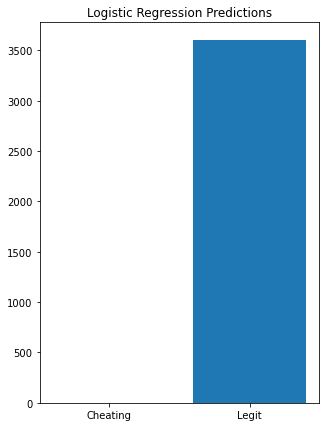

In [77]:
# Print bar graphs of predictions
fig = plt.figure(figsize=(5, 7))

labels = ['Cheating', 'Legit']
counts = [
    np.sum(lr_predicted == 1),
    np.sum(lr_predicted == 0)
]
ax = fig.add_subplot()
ax.bar(labels, counts)
ax.set_title('Logistic Regression Predictions')

It is notable that the model predicted all instances in the test set to be Legit players.

# Insights and Conclusion
**Logistic Regression** took a decent amount of time to train. Even then, it gave the best predictions given the circumstances of our dataset. Additionally, hyperparameter training also consumed a significant amount of time to execute with negligible improvements. Although it has similar accuracy percentages with our other models, It had a higher recall than the rest. This is more desirable as getting rid of cheaters is the priority; it may better to take the risk of banning innocents than to let cheaters ruin a server/game. This is the philosophy of many modern anti-cheats as false bans, which are usually repealed through manual appeals.

**Neural Network** gave one of the fastest learning times given the specifications of our machines as keras allowed us to utilize our GPUs (Nvidia RTX 3070) making it a contender in our model selection. However, the amount of false negatives makes it an undesirable choice for detecting cheaters. With regards to hyperparameter tuning, it took a short time to learn (considering the specifications of the PC used to train) with the caveat that it didn’t show significant improvements in accuracy.

**Naive Bayes**, similar to our neural network model, learned quickly and gave results similar to logistic regression as it had low precision and high recall. Although the accuracy, precision, and recall were lower than those in logistic regression—so we came to the conclusion that it is less effective than logistic regression but more desirable if time needed to be saved.

**Decision Tree** performed similar to the neural network’s metrics but without the benefit of its fast learning. This is because of the large amount of features that caused the decision tree to split a large amount of times. Despite having 5 main features for the dataset, the decision tree was tasked to split a feature set sized at 28,800 because the dimensions of the raw data needed to be flattened.

**Random Forest** performed like the rest in terms of accuracy but also performed slowly during learning. Random forest returned a precision of 1.0 (Flagged as a warning by `precision_score` and displayed as 0) and a recall of 0, but this is because it marked everything as legitimate players and did not detect any cheaters.

After looking at the precision and recall scores, we could say that the problem causing the accuracy to be the same with each other is the dataset. Looking back at the EDA section, we found that the scatter plots of the features of the datasets were very similar with each other, and some samples of Legit players matched the behavior of cheating players. The accuracy of the model came from the fact that it was predicting the majority class, which is the Legit players. Legit players comprised 10,000 out of 12,000 of the samples in the dataset—amounting to *83.33%*. In addition to a cheater and legit player's behavior being similar in some instances, the dataset was very skewed, leading to poor results in model training. With a better distributed proportion among the data, accuracy may have been higher. But as said earlier, there are behaviors in the Legit player dataset that appear the same as an instance from the Cheaters dataset, which also could have been a cause of error.


# User Input
To ask for user input would require a multidimensional array that is 30 by 192 by 5. 30 would be for the number of encounters to be examined, 192 would be for each game tick and 5 would be for the features (AttackerDeltaYaw, AttackerDeltaPitch, CrosshairToVictimYaw, CrosshairToVictimPitch, Firing).

Rather than having the user input all of these values, we will instead read the input from a file that will contain data of a player.

In [83]:
# Loading and viewing the input file
user_input = np.load('input.npy')
user_input

array([[[ 1.1000e-02,  0.0000e+00, -2.1562e+01, -8.0020e+01,
          0.0000e+00],
        [ 1.6000e-02, -1.6000e-02, -2.1647e+01, -8.0148e+01,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -2.1759e+01, -8.0290e+01,
          0.0000e+00],
        ...,
        [ 9.3000e-02, -2.6400e-01, -1.2019e+01, -1.2520e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -1.2029e+01, -1.2520e+00,
          0.0000e+00],
        [-3.8000e-02, -5.2700e-01, -1.1996e+01, -7.2500e-01,
          0.0000e+00]],

       [[ 4.3900e-01,  1.1500e-01, -3.9596e+01,  8.2232e+01,
          0.0000e+00],
        [ 3.0200e-01, -2.2500e-01, -4.0040e+01,  8.2470e+01,
          0.0000e+00],
        [ 2.5300e-01, -2.4700e-01, -4.0580e+01,  8.2742e+01,
          0.0000e+00],
        ...,
        [-1.9170e+00, -9.2300e-01, -7.6700e-01, -7.3390e+00,
          0.0000e+00],
        [-1.7910e+00, -1.3900e+00,  1.1720e+00, -5.9490e+00,
          0.0000e+00],
        [-4.3900e-01, -1.2520e+00,  1.8110e+00, 

In [84]:
# Defining the classifier method
def cheaterOrNot(playerInput):
    playerInput = playerInput.reshape(1, 28800)
    prediction = best_lr.predict(playerInput)
    if prediction == 0:
        print('The player is a LEGIT PLAYER.')
    elif prediction == 1:
        print('The player is a CHEATER.')

In [85]:
# Calling the classifier
cheaterOrNot(user_input)

The player is a LEGIT PLAYER.


# References

Bhandari, A. (2020). Feature Scaling for Machine Learning: Understanding the Difference Between Normalization vs. Standardization. *Analytics Vidhya*. https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

Brownlee, J. (2020). Tune Hyperparameters for Classification Machine Learning Algorithms. *Machine Learning Mastery*. https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

EMSTATSL (n.d.). CSGO cheating dataset. *Kaggle*. https://www.kaggle.com/datasets/emstatsl/csgo-cheating-dataset

Gong, D. (2022). Top 6 Machine Learning Algorithms for Classification. *Towards Data Science*. https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501

Hale, J. (2019). Don't Sweat the Solver Stuff. *Towards Data Science*. https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451

Keras (n.d.). Hyperparameter Tuning. *Keras*. https://keras.io/guides/keras_tuner/

Keras (n.d.). The Sequential Model. *Keras*. https://keras.io/guides/sequential_model/

TensorFlow (n.d.). tf.Keras.Sequential. *TensorFlow*. https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

TensorFlow (n.d.). Module: tf. *TensorFlow*. https://www.tensorflow.org/api_docs/python/tf